In [492]:
import numpy as np
import matplotlib.pyplot as plt

In [493]:
# we have a 6x9 grid of 54 squares
# we place a 1 layer thick wall around the outside
# each square has 4 values, up, down, left, right
# 0 = up, 1 = down, 2 = left, 3 = right

# Q values for each square, up, down, left, right for each square
maze_Q = np.zeros((6, 9, 4))

# going out of bounds is a -100 penalty
penalty = -10000000
maze_Q[0, :, 0] = penalty
maze_Q[:, 0, 2] = penalty
maze_Q[5, :, 1] = penalty
maze_Q[:, 8, 3] = penalty

# reaching the goal is a 1 reward
maze_Q[0, 7, 3] = 1
maze_Q[1, 8, 0] = 1

maze_Q[0, 8, 1] = 1

initial_maze_Q = maze_Q.copy()

# set the maze whene the walls are represented by "W" and the goal by "G" and the current position by "*" and the empty squares by "0"
maze_1 = [["0", "0", "0", "0", "0", "0", "0", "0", "G"],
        ["0", "0", "0", "0", "0", "0", "0", "0", "0"],
        ["0", "0", "0", "0", "0", "0", "0", "0", "0"],
        ["0", "0", "0", "0", "0", "0", "0", "0", "0"],
        ["0", "W", "W", "W", "W", "W", "W", "W", "W"],
        ["0", "0", "0", "*", "0", "0", "0", "0", "0"]]

maze_2 = [["0", "0", "0", "0", "0", "0", "0", "0", "G"],
        ["0", "0", "0", "0", "0", "0", "0", "0", "0"],
        ["0", "0", "0", "0", "0", "0", "0", "0", "0"],
        ["0", "0", "0", "0", "0", "0", "0", "0", "0"],
        ["0", "W", "W", "W", "W", "W", "W", "W", "0"],
        ["0", "0", "0", "*", "0", "0", "0", "0", "0"]]

# np.random.seed(29)

# going into the walls has -10000000 penalty
maze_Q[5:8, 0, 0] = penalty
maze_Q[3:8, 0, 1] = penalty
maze_Q[4, 8, 2] = -penalty

maze_action_count = np.zeros((6, 9, 4))

maze = maze_1.copy()


# np.random.seed(1)

In [494]:
def max_index(array):
    """ Returns the index of the maximum value of an array. If there are multiple maximum values, a random one is returned.

    Args:
        array (_type_): the array to find the maximum index of
    """
    max_value = np.max(array)
    max_index = np.where(array == max_value)[0]
    return np.random.choice(max_index)

In [495]:
# instead of giving the reward as the Q value, give the reward as it is only 1 when it is near the goal and 0 everywhere else

def move(x, y, a, maze):
    """ Gives the expected Q value of the next position for moving from the current position by taking action a.
    If the action is invalid, the current position is returned with a reward of -100.
    Actions are 0 = up, 1 = down, 2 = left, 3 = right.

    Args:
        x (_type_): the x coordinate of the current position
        y (_type_): the y coordinate of the current position
        a (_type_): the action to take, 0 = up, 1 = down, 2 = left, 3 = right
        maze_Q (_type_): the Q values for each square
    """
    
    # if the action makes the agent go out of bounds, return the current position with a reward of -10000
    # if the action makes the agent go into a wall, return the current position with a reward of -10000
    
    if a == 0:
        if x == 0:
            return x, y, 0
        elif maze[x-1][y] == "W":
            return x, y, 0
        elif maze[x-1][y] == "G":
            return x-1, y, 1
        else:
            return x-1, y, 0
    elif a == 1:
        if x == 5:
            return x, y, 0
        elif maze[x+1][y] == "W":
            return x, y, 0
        elif maze[x+1][y] == "G":
            return x+1, y, 1
        else:
            return x+1, y, 0
    elif a == 2:
        if y == 0:
            return x, y, 0
        elif maze[x][y-1] == "W":
            return x, y, 0
        elif maze[x][y-1] == "G":
            return x, y-1, 1
        else:
            return x, y-1, 0
    elif a == 3:
        if y == 8:
            return x, y, 0
        elif maze[x][y+1] == "W":
            return x, y, 0
        elif maze[x][y+1] == "G":
            return x, y+1, 1
        else:
            return x, y+1, 0
    else:
        print("Invalid action, the action a must be 0(up), 1(down), 2(left), or 3(right)")
        raise ValueError("Invalid action")

In [496]:
def update_Q(x, y, a, maze_Q, learning_rate, discount_factor, discount, maze):
    """ Updates the Q value for the current position and action.

    Args:
        x (_type_): the x coordinate of the current position
        y (_type_): the y coordinate of the current position
        a (_type_): the action to take, 0 = up, 1 = down, 2 = left, 3 = right
        maze_Q (_type_): the Q values for each square
        learning_rate (_type_): the learning rate
        discount_factor (_type_): the discount factor
    """
    # get the next position
    x_next, y_next, reward = move(x, y, a, maze)

    # update the Q value
    if discount:
        Nxa = -0.01 * np.sqrt(maze_action_count[x, y, a])
    else:
        Nxa = 0
    maze_Q[x, y, a] = (1 - learning_rate) * maze_Q[x, y, a] + learning_rate * (reward + Nxa + discount_factor * np.max(maze_Q[x_next, y_next, :]))
    
    return x_next, y_next

In [497]:
# set the learning rate
learning_rate = 0.5

# set the discount factor
discount_factor = 0.9

time_steps_1 = 4000
time_steps_2 = 2000

repetition = 10

In [498]:
# Q- learning
maze_Q = initial_maze_Q.copy()

for i in range(6):
    for j in range(9):
        print(f"{np.max(maze_Q[i, j, :]):.5f}", end=" ")
    print()

total_cumulative_reward = np.zeros(time_steps_1+time_steps_2)

for i in range(repetition):
    total_reward = 0

    cumulative_reward = []

    x, y = [5, 3]
    
    maze_Q = initial_maze_Q.copy()
    
    maze_action_count = np.zeros((6, 9, 4))
    
    for t in range(time_steps_1 + time_steps_2):
        
        a = max_index(maze_Q[x, y, :])
        
        maze_action_count[x, y, a] += 1
        
        total_reward += maze_Q[x, y, a]
        
        cumulative_reward.append(total_reward)

        if x == 0 and y == 8:
            x, y = update_Q(x, y, a, maze_Q, learning_rate, discount_factor, False, maze)
            x, y = [5, 3]
        else:
            x, y = update_Q(x, y, a, maze_Q, learning_rate, discount_factor, False, maze)

    
    # add cumulative reward to total cumulative reward
    total_cumulative_reward += np.array(cumulative_reward)
    
# take the average cumulative reward
total_cumulative_reward /= repetition    

dyna_q_minus_average_cumulative_reward = total_cumulative_reward.copy()


0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 1.00000 1.00000 
0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 1.00000 
0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 


In [499]:
# print an array which shows the maximum Q value for each square with 2 decimal places
for i in range(6):
    for j in range(9):
        print(f"{np.max(maze_Q[i, j, :]):.5f}", end=" ")
    print()

# print an array which shows the maximum Q value with letters u, d, l, r for each square
for i in range(6):
    for j in range(9):
        print("udlr"[max_index(maze_Q[i, j, :])], end=" ")
    print()

0.00000 0.00000 0.00000 0.00000 0.00000 1.46610 1.62900 1.81000 0.90000 
0.00000 0.00132 0.00000 0.00000 1.18754 1.31949 0.04101 1.39303 1.00000 
0.00664 0.77915 0.86572 0.96191 1.06879 0.00000 0.26882 0.78013 0.00000 
0.63111 0.70123 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
0.56800 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
0.51120 0.46008 0.41407 0.37266 0.00000 0.00000 0.00000 0.00000 0.00000 
d l r d r r r r d 
r d u d r u d u u 
r r r r u l r u d 
r u l u l u d r u 
u r u d r u l r l 
u l l l u r r r l 


In [500]:
# Q+ learning
maze_Q = initial_maze_Q.copy()

for i in range(6):
    for j in range(9):
        print(f"{np.max(maze_Q[i, j, :]):.5f}", end=" ")
    print()

total_cumulative_reward = np.zeros(time_steps_1+time_steps_2)

for i in range(repetition):
    total_reward = 0

    cumulative_reward = []

    x, y = [5, 3]
    
    maze_Q = initial_maze_Q.copy()
    
    maze_action_count = np.zeros((6, 9, 4))
    
    for t in range(time_steps_1 + time_steps_2):
        
        if t == 0:
            # switch to maze 1
            maze = maze_1.copy()
            maze_Q[5, 8, 0] = penalty
            maze_Q[3, 8, 1] = penalty
            maze_Q[4, 7, 3] = penalty
        elif t == time_steps_1:
            # switch to maze 2
            maze = maze_2.copy()
            maze_Q[5, 8, 0] = 0
            maze_Q[3, 8, 1] = 0
            maze_Q[4, 7, 3] = 0
        
        a = max_index(maze_Q[x, y, :])
        
        maze_action_count[x, y, a] += 1
        
        total_reward += maze_Q[x, y, a]
        
        cumulative_reward.append(total_reward)

        if x == 0 and y == 8:
            x, y = update_Q(x, y, a, maze_Q, learning_rate, discount_factor, True, maze)
            x, y = [5, 3]
        else:
            x, y = update_Q(x, y, a, maze_Q, learning_rate, discount_factor, True, maze)

    
    # add cumulative reward to total cumulative reward
    total_cumulative_reward += np.array(cumulative_reward)
    
# take the average cumulative reward
total_cumulative_reward /= repetition    

dyna_Q_plus_average_cumulative_reward = total_cumulative_reward.copy()


0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 1.00000 1.00000 
0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 1.00000 
0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 


In [501]:
# print an array which shows the maximum Q value for each square with 2 decimal places
for i in range(6):
    for j in range(9):
        print(f"{np.max(maze_Q[i, j, :]):.5f}", end=" ")
    print()

# print an array which shows the maximum Q value with letters u, d, l, r for each square
for i in range(6):
    for j in range(9):
        print("udlr"[max_index(maze_Q[i, j, :])], end=" ")
    print()

-0.08103 -0.06645 -0.04874 -0.00405 0.23744 0.82667 1.88107 3.18123 3.04087 
-0.08086 -0.06632 0.05511 -0.03434 0.03468 -0.00957 0.77737 3.04469 3.56919 
-0.09115 -0.04252 0.40066 0.92586 1.64595 1.98690 2.36604 2.57322 2.23758 
0.38836 0.59220 0.81680 1.06555 1.34102 -0.01345 1.08746 -0.00500 1.93548 
0.20157 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 1.66293 
0.03242 -0.12055 -0.25928 0.45039 0.60529 0.77705 0.96756 1.18308 1.41751 
r r d r r r r r d 
r d d u d d r r u 
r r r r r r r u l 
r r r r u r u u u 
u l r d d d u d u 
u l l r r r r r u 


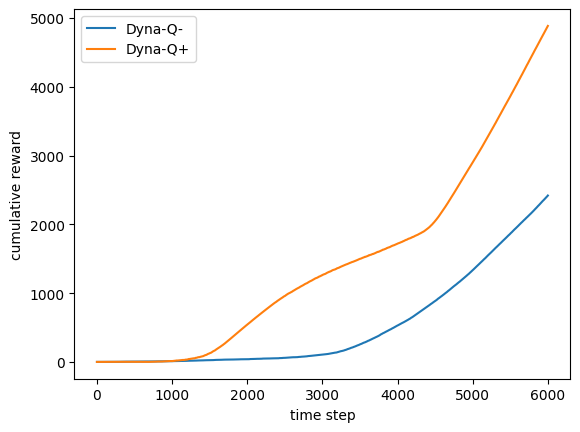

In [502]:
# plot the cumulative reward for both algorithms
plt.plot(dyna_q_minus_average_cumulative_reward, label="Dyna-Q-")
plt.plot(dyna_Q_plus_average_cumulative_reward, label="Dyna-Q+")
plt.legend()
plt.xlabel("time step")
plt.ylabel("cumulative reward")
plt.show()